In [1053]:
import pandas as pd

df = pd.read_csv("../data/coha-past-tense.txt", sep="\t", parse_dates=["year"])
df.head()

,genre,year,id,token,lemma
0,mag,1824-01-01,553520,served,serve
1,mag,1824-01-01,553520,seemed,seem
2,mag,1824-01-01,553520,yielded,yield
3,mag,1824-01-01,553520,sprang,spring
4,mag,1824-01-01,553520,constructed,construct


Newberry et al. describe a number of preprocessing steps, which we'll adopt:

In [1054]:
df = df[df["id"].notnull() & (df["lemma"].str.strip() != "")]

For some reason, the script provided by Newberry doesn't correct smell and clove on a mac. Probably has something to do with the version of sed shipped with macOS. 

In [1055]:
df.loc[(df["lemma"] == "smelt") & (df["token"] == "smelt"), "lemma"] = "smell"
df.loc[(df["lemma"] == "clove") & (df["token"] == "clove"), "lemma"] = "cleave"

Newberry et al. use the following list of lemma's:

In [1056]:
lemmas = (
    'awake', 'build', 'burn', 'catch', 'dive', 'draw', 'dream',
    'dwell', 'grow', 'hang', 'hear', 'heave', 'kneel', 'knit', 
    'know', 'lay', 'lean', 'leap', 'learn', 'light', 'plead', 
    'quit', 'shine', 'smell', 'sneak', 'speed', 'spell', 'spill', 
    'spoil', 'strew', 'tell', 'throw', 'wake', 'weave', 'wed', 'wet'
) 

In [1057]:
df = df[(df["id"] != 762347) & df["lemma"].isin(lemmas)]
df = df[~df['token'].isin(('drawn', 'grown', 'known', 'layed'))]
df.head()

,genre,year,id,token,lemma
24,mag,1824-01-01,553520,laid,lay
65,mag,1824-01-01,553520,grew,grow
137,mag,1826-01-01,553768,grew,grow
145,mag,1826-01-01,553768,burnt,burn
172,mag,1827-01-01,553857,grew,grow


Follow Newberry et al in determining whether a token is a regular or irregular form of a verb:

In [1058]:
def is_regular(group):
    variants = group["token"].unique()
    regular = max(variants, key=len)
    irregular = min(variants, key=len)
    group['regular'] = (group['token'] == regular).astype(int)
    return group

df = df.groupby('lemma').apply(is_regular)

In [1059]:
df.head()

,genre,year,id,token,lemma,regular
24,mag,1824-01-01,553520,laid,lay,1
65,mag,1824-01-01,553520,grew,grow,0
137,mag,1826-01-01,553768,grew,grow,0
145,mag,1826-01-01,553768,burnt,burn,0
172,mag,1827-01-01,553857,grew,grow,0


In [1060]:
df.loc[df['lemma'].isin(lemmas), 'lemma'].value_counts()

know     171518
tell     129041
hear      72052
lay       66436
grow      37444
draw      35213
throw     25612
catch     25529
learn     18851
lean      16981
hang      16079
build      9109
light      8869
shine      8424
leap       8336
wake       7186
burn       6097
kneel      5185
awake      4926
smell      4555
dream      4530
plead      3810
speed      3142
quit       2734
heave      2392
dwell      1621
spill      1178
spoil      1045
dive       1036
spell       962
weave       907
sneak       898
wet         770
strew       727
knit        675
wed         211
Name: lemma, dtype: int64

In [1061]:
# Sanity checks
df.loc[df["lemma"] == "wet", "regular"].sum() == 72
df.loc[df["lemma"] == "awake", "regular"].sum() == 74
df.loc[df["lemma"] == "lean", "regular"].sum() == 16716
df.loc[df["lemma"] == "spell", "regular"].sum() == 867

True

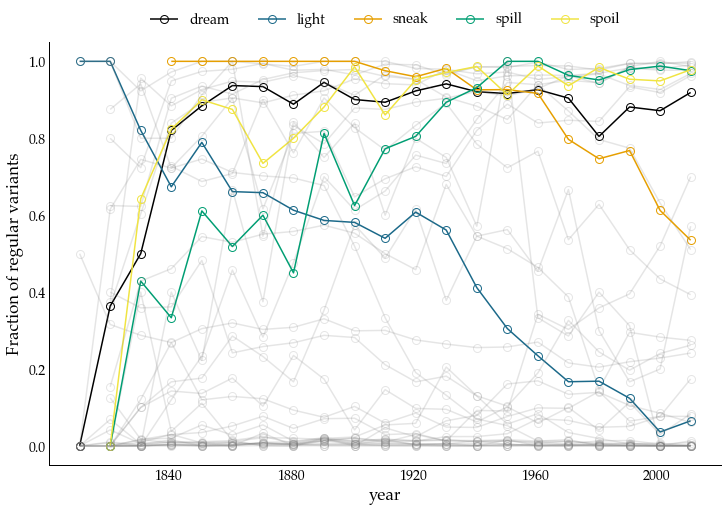

In [1809]:
import matplotlib.pyplot as plt
plt.style.use("tufte")

freqs = df.groupby([pd.Grouper(key='year', freq='10y'), 'lemma'])['regular'].apply(
    lambda x: x.sum() / x.shape[0]).unstack()

fig, ax = plt.subplots()

lemmas_for_plot = ("spill", "light", "dream", "sneak", "spoil")
for lemma in lemmas:
    if lemma in lemmas_for_plot:
        ax.plot(freqs[lemma], "-o", label=lemma)
    else:
        ax.plot(freqs[lemma], '-o', color="grey", alpha=0.2)

ax.set(ylabel="Fraction of regular variants", xlabel="year")

plt.legend(loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.1), frameon=False)
plt.savefig("../overleaf/paper/plots/past-tense-examples.png", transparent=True, dpi=300)

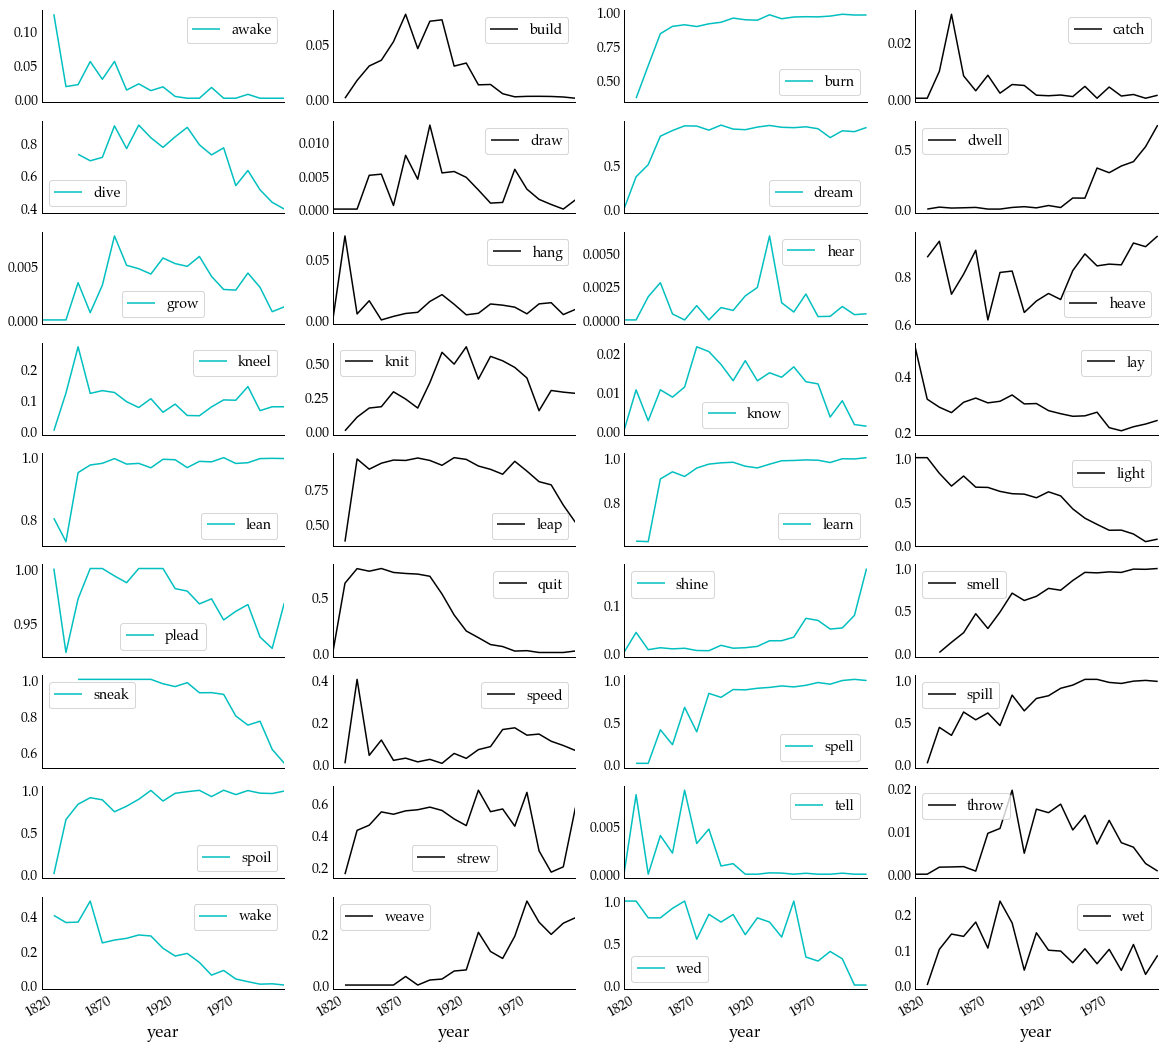

In [1265]:
freqs.plot(subplots=True, layout=(9, 4), figsize=(20, 20), color="c0");

In [1223]:
directions = {
    'awake': "down", 
    'build': "none", 
    'burn': "none", 
    'catch': "none", 
    'dive': "down", 
    'draw': "none", 
    'dream': "none",
    'dwell': "none", 
    'grow': "none", 
    'hang': "none", 
    'hear': "none", 
    'heave': "none", 
    'kneel': "none", 
    'knit': "none", 
    'know': "none", 
    'lay': "none", 
    'lean': "none", 
    'leap': "none", 
    'learn': "none", 
    'light': "down", 
    'plead': "down", 
    'quit': "down", 
    'shine': "none", 
    'smell': "none", 
    'sneak': "down", 
    'speed': "none", 
    'spell': "none", 
    'spill': "none", 
    'spoil': "none", 
    'strew': "none", 
    'tell': "none", 
    'throw': "none", 
    'wake': "down", 
    'weave': "none", 
    'wed': "down", 
    'wet': "none"
}

In [902]:
%run ../src/fit.py

In [1076]:
def make_binnings(df, binnings):
    for binning in binnings:
        # Follow Karjus et al. in how bins are defined:
        freqs = df.groupby(pd.cut(
            df.year, pd.date_range('1810', '2010', freq=f'{binning}YS'),
            right=True, include_lowest=True
        ))['regular'].agg(value="sum", count="size")

#         # Alternative binnings strategy:
#         freqs = df.groupby(pd.Grouper(
#             key="year", 
#             freq=f'{binning}YS',
#             closed="right",
#         ))['regular'].agg(value="sum", count="size")

        # Apply smoothing as defined in Newberry
        max_abs = freqs["value"] == freqs["count"]
        min_abs = freqs["value"] == 0
        freqs.loc[max_abs, "value"] = freqs.loc[max_abs, 'count'] - 1
        freqs.loc[min_abs, "value"] = 1
        
        # Apply frequency threshold as suggested by Karjus et al.
        freqs = freqs[freqs['count'] >= 10]  
        freqs = freqs["value"] / freqs["count"]
        yield freqs

In [1625]:
def draw_pie_fit(dist, xpos, ypos, size, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum / cumsum[-1]
    pie = [0] + cumsum.tolist()

    for i, (r1, r2) in enumerate(zip(pie[:-1], pie[1:])):
        if dist[i] > 0:
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size, color=f"C{i if i != 0 else i}", alpha=1-int(i==3))

    return ax

def make_fit_plot(results, lemmas=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 10))
    
    if lemmas is None:
        lemmas = list(fit_results.keys())
        
    X_fit = np.zeros((len(binnings), len(lemmas)), dtype=int)
    X_norm = np.zeros((len(binnings), len(lemmas)), dtype=int)
    
    for i, lemma in enumerate(lemmas):
        for j, (Tp, Wp) in enumerate(results[lemma]):
            X_fit[j, i] = 3 if Tp is None else 2 if Tp < 0.05 else 1 if Tp < 0.2 else 0
            X_norm[j, i] = 3 if Wp is None else 0 if Wp > 0.1 else 1

    markers = "o", "s"
    for i, row in enumerate(X_fit):
        for color in (0, 1, 2):
            for marker in (0, 1):
                pos = np.where((row == color) & (X_norm[i] == marker))[0]
                ax.plot(
                    [i] * len(pos), pos, 
                    markers[marker], 
                    color=f"C{color}",
                    markerfacecolor=f"C{color}" if color != 0 else None,
                    markersize=12
                )
                
    for i, lemma in enumerate(lemmas):
        X = X_fit[:, i]
        X[X_norm[:, i] == 1] = 3
        draw_pie_fit(np.bincount(X), len(binnings) + 1, i, size=120, ax=ax)
            
    ax.set_xticks(range(len(binnings)))
    
    for tick in ax.get_xaxis().get_major_ticks():
        tick.set_pad(-16.)
        tick.label1 = tick._get_text1()

    ax.set_xticklabels([f'{b}' for b in binnings])     

    ax.set_yticks(range(len(verbs)))
    ax.set_yticklabels(verbs)
    
    for tick in ax.get_yaxis().get_major_ticks():
        tick.set_pad(16.)
        tick.label1 = tick._get_text1()
    
    ax.xaxis.tick_top()
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

In [1441]:
binnings = 1, 5, 10, 15, 20, 25, 40

fit_results = {lemma: [None] * len(binnings) for lemma in lemmas}
for lemma in lemmas:
    d = df[df["lemma"] == lemma]
    for i, freqs in enumerate(make_binnings(d, binnings)):
        if freqs.shape[0] >= 3:
            fit = frequency_increment_test(
                [bin.left.year for bin in freqs.index], freqs.values, clip=False)
            fit_results[lemma][i] = fit['Tp'], fit['Wp']
        else:
            fit_results[lemma][i] = None, None

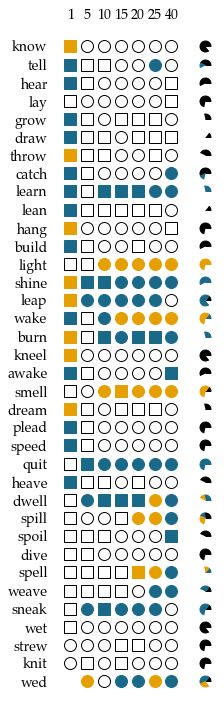

In [1626]:
from matplotlib.lines import Line2D

verbs = df.loc[df['lemma'].isin(lemmas), 'lemma'].value_counts().sort_values().index

make_fit_plot(fit_results, lemmas=verbs)
plt.savefig("../overleaf/paper/plots/past-tense-fit.png", dpi=300, transparent=True)

In [1161]:
%run ../src/nets.py

In [1797]:
import tqdm
import scipy.stats as stats

binnings = 1, 5, 10, 15, 20, 25, 40

runid = '7ff24a9c'

net = ResNet(1)
net.load_state_dict(
    torch.load(f"../results/interesting/{runid}.pt", 
    map_location=torch.device('cpu'))["state_dict"]
)
net.eval()

nn_results = {lemma: [None] * len(binnings) for lemma in lemmas}
for lemma in lemmas:
    d = df[df["lemma"] == lemma]
    for i, freqs in enumerate(make_binnings(d, binnings)):
        if directions[lemma] == "down":
            freqs = 1 - freqs
        if freqs.shape[0] >= 3:
            freqs = torch.FloatTensor([freqs.values])
            with torch.no_grad():
                nn_results[lemma][i] = torch.sigmoid(net(freqs.unsqueeze(1)))[0][0]
        else:
            nn_results[lemma][i] = None

In [1798]:
import scipy.stats as stats

def draw_pie_nn(dist, xpos, ypos, size, ax=None):
    if dist.shape[0] >= 3:
        dist = dist[[i for i in range(dist.shape[0]) if i != 1]]
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for i, (r1, r2) in enumerate(zip(pie[:-1], pie[1:])):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size, color=f"C{i+1 if i != 0 else i}", alpha=1-int(i==2))

    return ax

def make_nn_plot(results, lemmas=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 10))
    
    if lemmas is None:
        lemmas = list(results.keys())
        
    X = np.zeros((len(binnings), len(lemmas)), dtype=int)
    
    for i, lemma in enumerate(lemmas):
        for j, p in enumerate(results[lemma]):
            X[j, i] = 3 if p is None else 2 if p > 0.5 else 0

    for i, row in enumerate(X[::-1], 2):
        for color in (0, 2):
            pos = np.where(row == color)[0]
            ax.plot(
                [i] * len(pos), pos,
                'o', 
                color=f"C{color}",
                markerfacecolor=f"C{color}" if color != 0 else None,
                markersize=12
            )
            
    for i, lemma in enumerate(lemmas):
        draw_pie(np.bincount(X[:, i]), 0, i, size=120, ax=ax)
            
    ax.set_xticks(range(len(binnings) + 2))
    ax.set_xticklabels([''] * 2 + [f'{b}' for b in binnings[::-1]])
    
    for tick in ax.get_xaxis().get_major_ticks():
        tick.set_pad(-16.)
        tick.label1 = tick._get_text1()
        
    ax.xaxis.tick_top()
    
    ax.set_yticks(range(len(verbs)))
    ax.set_yticklabels(verbs)
    
    for tick in ax.get_yaxis().get_major_ticks():
        tick.set_pad(16.)
        tick.label1 = tick._get_text1()
        
    ax.yaxis.tick_right()  
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

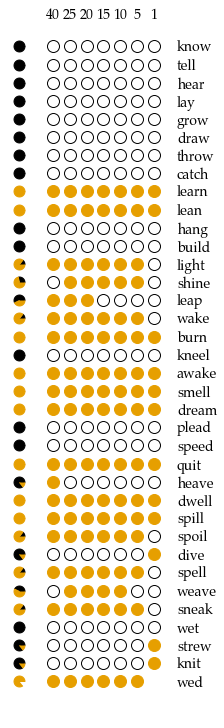

In [1799]:
make_nn_plot(nn_results, lemmas=verbs)
plt.savefig(f"../overleaf/paper/plots/past-tense-nn.png", dpi=300, transparent=True)

In [1801]:
len(verbs)

36

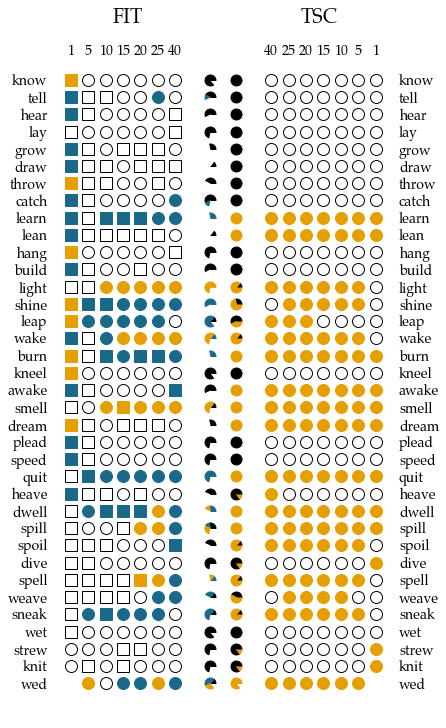

In [1800]:
fig, (fit_ax, nn_ax) = plt.subplots(ncols=2, figsize=(6, 10))

make_fit_plot(fit_results, lemmas=verbs, ax=fit_ax)
make_nn_plot(nn_results, lemmas=verbs, ax=nn_ax)
fit_ax.set_title("FIT", pad=20, x=0.4)
nn_ax.set_title("TSC", pad=20, x=0.6)
fig.set_constrained_layout_pads(wspace=0, w_pad=0)

plt.savefig(f"../overleaf/paper/plots/past-tense-nn.png", dpi=300, transparent=True)